The estimation of Feature Importance based on a xgboost regression model. 

After removing the features with correlation value higher than 0.99, analyzing on the input data of the model was done to estimate the most important
features with respect to a xgboost model.
The Feature Importance is done according to two different approaches: 1.SHAP values which used to explain how each
feature affects the model and 2.xgboost Built-in Feature Importance(The XGBoost library provides a built-in function to plot features ordered by their importance).

In [ ]:
%load_ext jupyter_black

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor

In [ ]:
from utils import get_clean_dataset

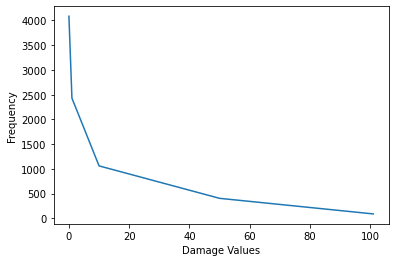

In [3]:
#The Old and New set of bins
bins2= [0, 1, 60, 101]
#bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [4]:
print(samples_per_bin2)
print(binsP2)

[4086 2431 1061  405   90]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [5]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [6]:
y_input_strat=bin_index2

In [7]:
#Dropping highly correlated features (correlation value > 0.99) from X data.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary']

X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2, 
                                                    #random_state=42
                                                   ) 


#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)


Index(['HAZ_rainfall_Total', 'HAZ_v_max', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl', 'TOP_mean_slope',
       'GEN_with_coast', 'GEN_coast_length', 'VUL_Housing_Units',
       'VUL_StrongRoof_StrongWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall'],
      dtype='object')

In [8]:
# create an xgboost regression model

#XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8 
                   #,random_state=42
                  )
xgb_model=xgb.fit(X_train, y_train)


#XGBoost ReducedOverfitting
#xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
#                   colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
#                   importance_type='gain', learning_rate=0.1, max_delta_step=0,
#                   max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
#                   n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
#                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#                   silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"])

    
#eval_set = [(X_test, y_test)]
#xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


In [9]:
X_train4shapely=pd.DataFrame(data=X_train,columns=features)

In [10]:
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)


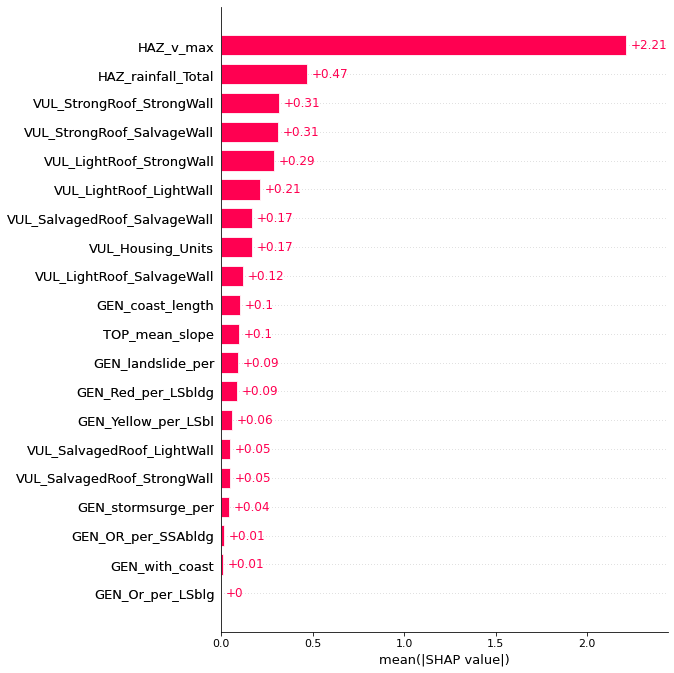

In [11]:
#Showing Barplot

#shap.plots.beeswarm(shap_values_xgb.abs, color="shap_red", max_display=20)
#shap.plots.bar(shap_values_xgb.abs.mean(0), max_display=20)

shap.plots.bar(shap_values_xgb, max_display=20)

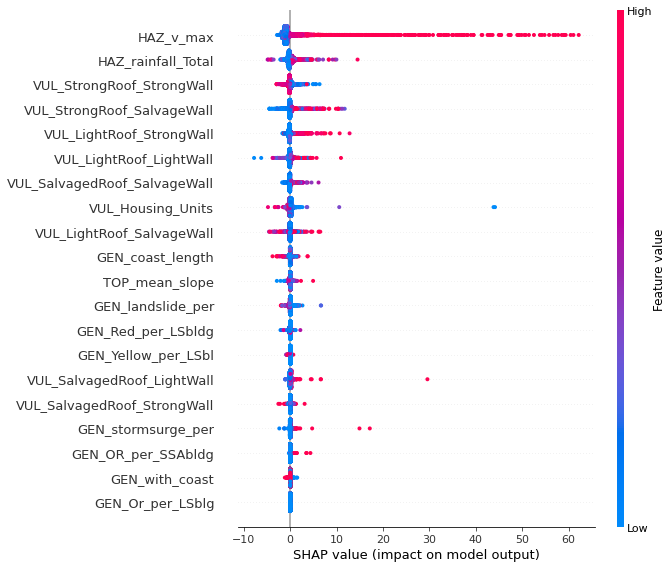

In [12]:
#Showing Beeswarm Plot
shap.plots.beeswarm(shap_values_xgb, max_display=20, #order=shap_values_xgb.abs.max(0)#, color="shap_red"
                   )

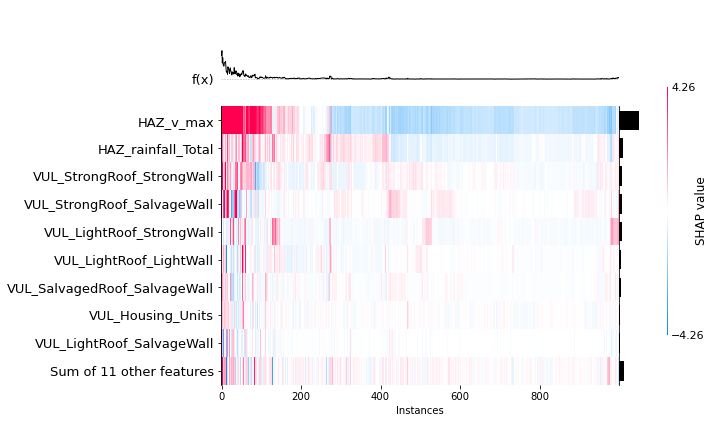

In [13]:
#Showing Heatmap 
shap.plots.heatmap(shap_values_xgb[:1000])

Text(0.5, 0, 'Xgboost Feature Importance')

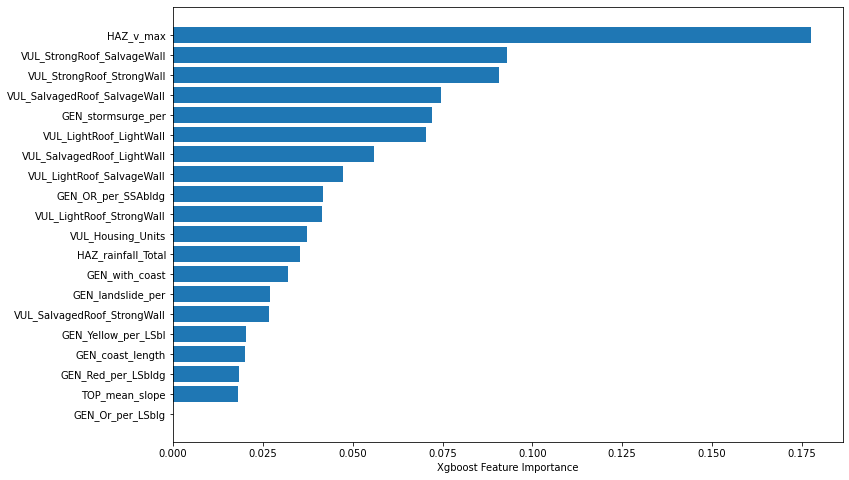

In [14]:
#Xgboost Built-in Feature Importance

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 10})

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

import shap explainer = shap.TreeExplainer(xgb) shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [15]:
"""
Showing X data illustrates that 5 highly correlated features with the value higher than 0.99 were removed 
before applying feature importance methods on input data.
"""
X

,HAZ_rainfall_Total,HAZ_v_max,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,GEN_OR_per_SSAbldg,GEN_Yellow_per_LSbl,TOP_mean_slope,GEN_with_coast,GEN_coast_length,VUL_Housing_Units,VUL_StrongRoof_StrongWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall
0,185.828571,55.032241,2.64,6.18,1.17,0.03,0.00,0.06,16.48,1.0,37836.0,7185.0,46.109951,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507
2,8.818750,8.728380,0.06,0.00,0.06,0.00,0.00,0.00,8.73,1.0,38796.0,13294.0,49.443358,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833
4,24.175000,10.945624,1.52,1.28,0.02,0.00,0.00,0.00,4.58,1.0,36607.0,6593.0,59.563173,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838
6,14.930000,12.108701,0.00,0.00,0.00,0.00,0.00,0.00,8.77,0.0,0.0,8591.0,75.183331,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041
7,13.550000,10.660943,5.52,0.36,0.00,0.00,0.00,0.00,9.83,1.0,311.0,3044.0,36.038108,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,9.700000,8.136932,1.80,6.25,0.12,0.00,0.00,0.00,6.67,1.0,13107.0,3210.0,43.457944,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153
25837,17.587500,9.818999,0.00,0.00,0.00,0.00,0.00,0.00,0.79,0.0,0.0,14350.0,80.432056,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561
25838,11.487500,15.791907,0.06,0.09,0.06,0.00,0.00,0.09,7.70,0.0,0.0,4439.0,73.710295,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528
25839,11.600000,13.867145,0.00,0.00,0.00,0.00,0.00,0.00,11.17,0.0,0.0,1058.0,66.257089,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000
